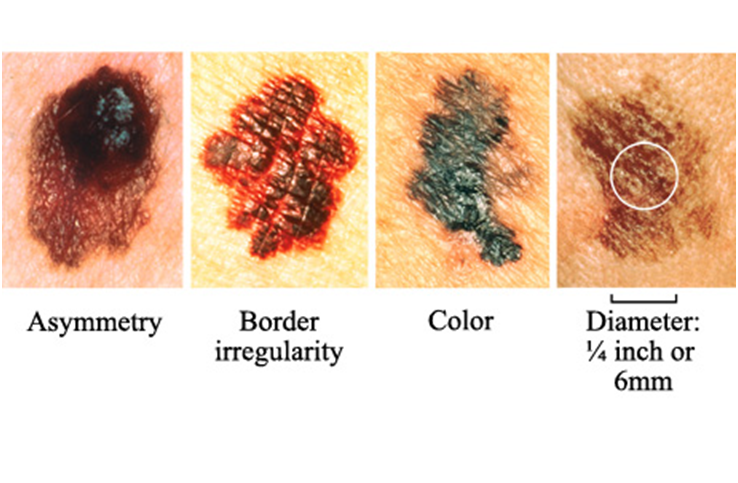

# Skin Lesion Classification: Cancer or Not?
**By: Sameeha Ramadhan**

# Introduction:

The goal of this project is to build a tool to correctly identify if whether or not a skin lesion is cancerous. The model will take in a picture of said lesion and calculate the probability that said lesion is benign (non-cancerous) or malignant (cancer). 

## Business Problem:

# Import:

The following packages run the models:

In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette("flare", as_cmap=True)

from keras.preprocessing import image
from keras.models import Model, Sequential
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

#!pip install efficientnet <---installed

import efficientnet.keras as efn
from keras.applications.resnet50 import ResNet50
from keras import regularizers 
from keras.regularizers import l2

import keras
import keras.backend
from IPython.display import display

import cv2


from skimage.io import imread
from skimage.transform import resize
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

np.random.seed(20)

# Data Exploration

I'll begin by first accessing the main directory and listing its contents:

In [2]:
main_dir = 'C:\\Users\\15164\\Desktop\\data\\'
data_directory = os.listdir('C:\\Users\\15164\\Desktop\\data\\')
print(data_directory)

['test', 'train']


Next, I'll print the contents of each sub directory and the number of files each folder contains.

**Note: this notebook was run on a sample of the original dataset, which contains over 28,000 images. I've previously ran my models over the entire dataset, however my kernel kept crashing after days of running models and I had to keep restarting. I am currently running a separate notebook in batches and will update when completed.**

In [17]:
for _set in ['test', 'train']:
    x_benign = len(os.listdir(main_dir + _set + '/benign'))
    x_malignant = len(os.listdir(main_dir + _set + '/malignant'))
    print('Set: {}, Benign Images: {}, Malignant Images: {}, Total: {}'.format(_set, x_benign,
                                                                                x_malignant, (x_benign + x_malignant)))

Set: test, Benign Images: 360, Malignant Images: 300, Total: 660
Set: train, Benign Images: 1440, Malignant Images: 1197, Total: 2637


A simple plot to confirm the images have successfully loaded, and then I will check the balance of the data:

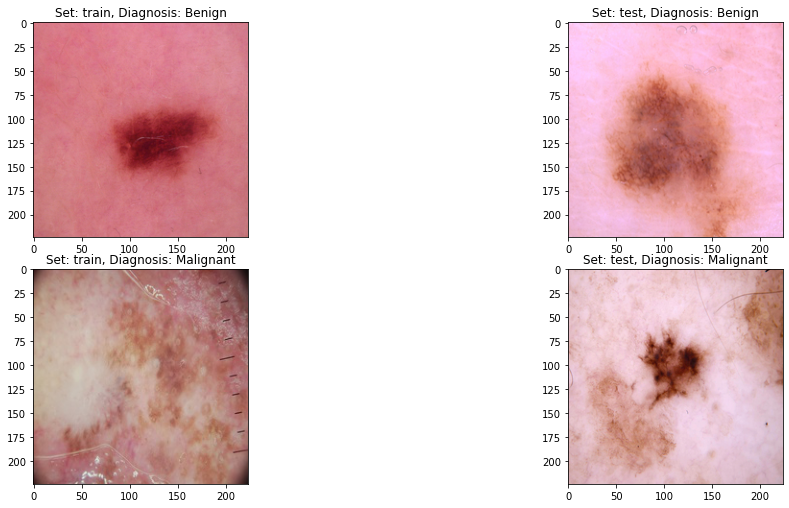

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = main_dir+_set
    ax[i].imshow(plt.imread(set_path+'/benign/'+os.listdir(set_path+'/benign')[1]), cmap='gist_gray')
    ax[i].set_title('Set: {}, Diagnosis: Benign'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/malignant/'+os.listdir(set_path+'/malignant')[1]), cmap='gist_gray')
    ax[i+2].set_title('Set: {}, Diagnosis: Malignant'.format(_set))

## Checking Data Balance:

In [3]:
train_dir = os.path.join(main_dir, "train\\")
test_dir = os.path.join(main_dir, "test\\")

I'll create dataframes to plot the data and check its distribution:

In [20]:
#Train data:
train_df = []

benign_set = os.path.join(train_dir,'benign')
malignant_set = os.path.join(train_dir,'malignant')

#Image list:

benign_images = glob(benign_set+"/*.jpg") + glob(benign_set+"/*.jpeg") + glob(benign_set+"/*.png")
malignant_images = glob(malignant_set + "/*.jpg") + glob(malignant_set + "/*.jpeg") + glob(malignant_set + "/*.png")

#Benign scans are labeled 0:
for img in benign_images:
    train_df.append((img, 0))

#Malignant are labeled 1:
for img in malignant_images:
    train_df.append((img, 1))

#Creating a dataframe:
train_df = pd.DataFrame(train_df, columns=['Image', 'Diagnosis'], index=None)

In [21]:
#Test data:
test_df = []

benign_set = os.path.join(test_dir,'benign')
malignant_set = os.path.join(test_dir,'malignant')

#Image list:
benign_images = glob(benign_set+"/*.jpg") + glob(benign_set+"/*.jpeg") + glob(benign_set+"/*.png")
malignant_images = glob(malignant_set + "/*.jpg") + glob(malignant_set + "/*.jpeg") + glob(malignant_set + "/*.png")

#Benign scans are labeled 0:
for img in benign_images:
    test_df.append((img, 0))

#Malignant are labeled 1:
for img in malignant_images:
    test_df.append((img, 1))

#Create the dataframe:
test_df = pd.DataFrame(test_df, columns=['Image', 'Diagnosis'], index=None)

## Plotting Binary Data:

In [22]:
def balance_check(data):
#'data': the dfs we've created
    image_count = data['Diagnosis'].value_counts()
    print('Counts:')
    print(image_count)
    
    plt.figure(figsize=(11,7))
    sns.barplot(x= image_count.index, y= image_count.values)
    plt.title('Plot of Diagnosis Balancing', fontsize= 14)
    plt.xlabel('Diagnosis', fontsize= 11)
    plt.ylabel('Image Count', fontsize= 11)
    plt.xticks(range(len(image_count.index)), ['Benign(0)', 'Malignant(1)'])
    plt.show()

Counts:
0    1440
1    1197
Name: Diagnosis, dtype: int64


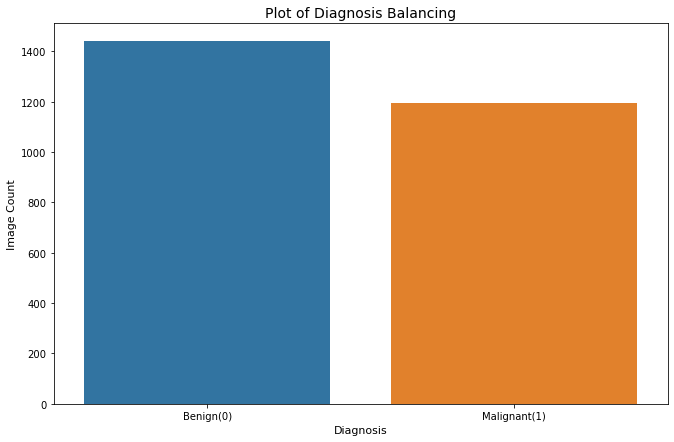

In [24]:
balance_check(train_df)

Counts:
0    360
1    300
Name: Diagnosis, dtype: int64


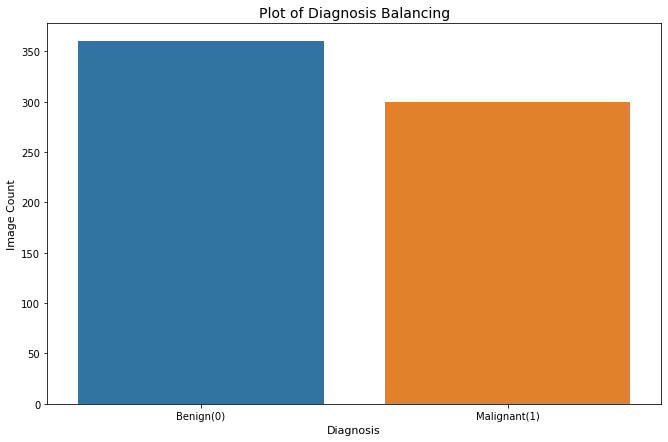

In [25]:
balance_check(test_df)

### Model Visualization Function:

Now I'll define a function that plots the accuracy and loss results of my CNN models for easy interpretation:

In [42]:
def model_performance(history):
    
    history_dict = history.history
    train_loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']#<--'val' here is for validation, and will be from the 'test' dataset
    train_accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(8,8))
    
    #Plotting loss results:    
    epochs = range(1, len(val_loss_values) + 1) #epoch: the number of times the model will be fit on the training set.
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=train_loss_values, label='Train Loss')
    
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=val_loss_values, label='Val Loss')
    plot1.set(xlabel='Epochs', ylabel='Loss')
    plot1.axes.set_title('Model Loss', fontsize=18)
    plot1.grid(b=True, which='major', axis='y') #To show the grid lines or not
    
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=train_accuracy, label='Train Accuracy')
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=val_accuracy, label='Val Accuracy')
    plot2.set(xlabel='Epochs', ylabel='Accuracy')
    plot2.axes.set_title('Model Accuracy', fontsize=20)
    plot2.grid(b=True, which='major', axis='y')
    
    plt.tight_layout()
    plt.show()

# Model 1: CNN w/No Augmentation:

In [180]:
from decimal import * #<--The decimal import provides functions for operating on numbers represented as decimals. (1)
from keras.preprocessing.image import  load_img
from keras.models import load_model 
import glob as glob

In [38]:
#Input values:
img_width=128
img_height=128
batch_size=64
input_shape=(img_width,img_width,3)

Next I'll define my classes and resize the images:

In [240]:
label = ['benign','malignant']

path = {}
x_train=[]
y_train=[]
classs=0
for img in label:
    path[img] = glob.glob(os.path.join(r'C:\\Users\\15164\\Desktop\\data\\train\\', img, '*'))
    for image in path[img]:
        x_train.append(cv2.resize(cv2.imread(image),(img_width,img_width)))
        y_train.append(classs)
    classs=classs+1
    print(len(path[img]))

1440
1197


In [241]:
path = {}
x_test=[]
y_test=[]
classs=0
for img in label:
    path[img] = glob.glob(os.path.join(r'C:\\Users\\15164\\Desktop\\data\\test\\', img, '*'))
    for image in path[img]:
        x_test.append(cv2.resize(cv2.imread(image),(img_width,img_width)))
        y_test.append(classs)
    classs=classs+1
    print(len(path[img]))

360
300


A quick check that images can be loaded:

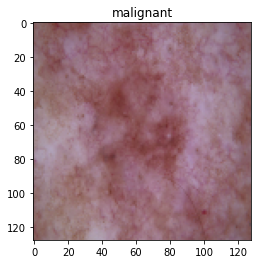

In [185]:
plt.imshow(cv2.cvtColor(x_train[-1], cv2.COLOR_BGR2RGB)) #<--Converting BGR image to RGB since image processing 
#libraries have different pixel orderings. (2)
plt.title(label[y_train[-1]])
plt.show()

In [186]:
#Normalization
x_train =  np.array(x_train[:])
x_train =  x_train / 255

Now on to defining my model's architecture:

In [276]:
model5 = Sequential()

model5.add(Conv2D(32, (3,3), input_shape = (input_shape), activation = 'relu'))
model5.add(MaxPooling2D(pool_size = (2, 2)))
model5.add(Dropout(0.2))


model5.add(Conv2D(32, (3,3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size = (2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv2D(64, (3,3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size = (2, 2)))
model5.add(Dropout(0.2))

model5.add(Flatten())

model5.add(Dense(units = 4096, activation = 'relu'))
model5.add(Dense(units = 2048, activation = 'relu'))
model5.add(Dropout(0.2))

model5.add(Dense(units = len(label), activation = 'softmax'))


model5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 64)      

I'll compile my model using sparse categorical crossentropy as my loss since my classes are mutually exclusive (meaning each sample belongs exactly to one class). (3) Also, due to the nature of my original dataset(very large and contains images that are very noisy with a lot of gradients) I'll optimize using 'Adam' because it is computationally efficient, has little memory requirements, the most suitable for problems that are large in terms of data and/or parameters, and is appropriate for problems with gradients. (4)

In [277]:
model5.compile(loss = 'sparse_categorical_crossentropy', optimizer ='adam', metrics = ['accuracy'])

And now, we train our model:

In [189]:
hist = model5.fit(x_train, np.array(y_train),epochs=100,batch_size=64)

Epoch 1/100
42/42 [==============================] - 75s 2s/step - loss: 1.2936 - accuracy: 0.5745
Epoch 2/100
42/42 [==============================] - 60s 1s/step - loss: 0.5352 - accuracy: 0.7383
Epoch 3/100
42/42 [==============================] - 57s 1s/step - loss: 0.4880 - accuracy: 0.7672
Epoch 4/100
42/42 [==============================] - 57s 1s/step - loss: 0.4376 - accuracy: 0.7838
Epoch 5/100
42/42 [==============================] - 57s 1s/step - loss: 0.4220 - accuracy: 0.7994
Epoch 6/100
42/42 [==============================] - 58s 1s/step - loss: 0.3949 - accuracy: 0.8051
Epoch 7/100
42/42 [==============================] - 58s 1s/step - loss: 0.3864 - accuracy: 0.8089
Epoch 8/100
42/42 [==============================] - 59s 1s/step - loss: 0.3761 - accuracy: 0.8127
Epoch 9/100
42/42 [==============================] - 58s 1s/step - loss: 0.3555 - accuracy: 0.8290
Epoch 10/100
42/42 [==============================] - 58s 1s/step - loss: 0.3587 - accuracy: 0.8153
Epoch 11/

42/42 [==============================] - 56s 1s/step - loss: 0.0171 - accuracy: 0.9932
Epoch 84/100
42/42 [==============================] - 60s 1s/step - loss: 0.0245 - accuracy: 0.9932
Epoch 85/100
42/42 [==============================] - 59s 1s/step - loss: 0.0095 - accuracy: 0.9973
Epoch 86/100
42/42 [==============================] - 58s 1s/step - loss: 0.0557 - accuracy: 0.9833
Epoch 87/100
42/42 [==============================] - 58s 1s/step - loss: 0.0196 - accuracy: 0.9920
Epoch 88/100
42/42 [==============================] - 59s 1s/step - loss: 0.0091 - accuracy: 0.9973
Epoch 89/100
42/42 [==============================] - 56s 1s/step - loss: 0.0114 - accuracy: 0.9962
Epoch 90/100
42/42 [==============================] - 56s 1s/step - loss: 0.0095 - accuracy: 0.9973
Epoch 91/100
42/42 [==============================] - 56s 1s/step - loss: 0.0032 - accuracy: 0.9985
Epoch 92/100
42/42 [==============================] - 56s 1s/step - loss: 0.0065 - accuracy: 0.9985
Epoch 93/100


## Evaluate:

In [243]:
scores = model5.evaluate(x_test,np.array(y_test))
print("Accuracy = " + format(scores[1]*100, '.2f') + "%") #<-- "".2f" to print 2 decimal places as a string and float (5)

21/21 [==============================] - 8s 379ms/step - loss: 0.9207 - accuracy: 0.8379
Accuracy = 83.79%


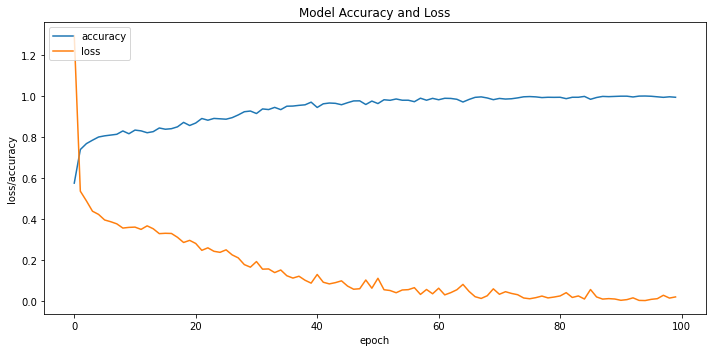

In [225]:
fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
plot1= plt.plot(hist.history['accuracy'])
plot2=plt.plot(hist.history['loss'])
plot2=plt.title('Model Accuracy and Loss')
plot2=plt.ylabel('loss/accuracy')
plot2=plt.xlabel('epoch')
plot2=plt.legend(['accuracy', 'loss'], loc='upper left')

plt.tight_layout()
plt.show()

As we can see from the accuracy score and the above accuracy/loss plot, our intial model performed well on our training set with a 99.3% accuracy and 0.019 loss. However, it's performed fairly decent on our test set, gaining an accuracy score of 83%.

# Model 2: EfficientNetB0

For my next model I've chosen to use EfficientNetB0, a pretrained image classification model that is optimized for state of the art accuracy while being smaller and faster. I've chosen this model because it comes from a family of models that have faster training speed and better parameter efficiency. [For more on EfficientNet models see references below]

In [24]:
#To free up memory space since our dataset is so large (the kernel kept crashing):
tf.keras.backend.clear_session()

In [107]:
s = 20
np.random.seed(s)
tf.random.set_seed(s)

In [108]:
#Resizing the images to a uniform size (a bit smaller than the usual 224 to save some memory space)
def resize_images(directory, resize):
    images = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for image_name in os.listdir(directory):
        PATH = os.path.join(directory, image_name)
        _, ftype = os.path.splitext(PATH)
        if ftype.endswith((".jpg", ".jpeg", ".png")):
            img = read(PATH)
            img = cv2.resize(img, (resize, resize))
            images.append(np.array(img)/255.) #<-- EfficientNet models require inputs to be float tensors of pixels
            #w/ values in the [0-255] range.
    return images

In [249]:
benign_train = np.array(resize_images('C:\\Users\\15164\\Desktop\\data\\train\\benign', 128))

In [250]:
malign_train = np.array(resize_images('C:\\Users\\15164\\Desktop\\data\\train\\malignant', 128))

In [251]:
benign_test = np.array(resize_images('C:\\Users\\15164\\Desktop\\data\\test\\benign', 128))

In [252]:
malign_test = np.array(resize_images('C:\\Users\\15164\\Desktop\\data\\train\\malignant', 128))

In [253]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merging
x_train = np.concatenate((benign_train, malign_train), axis = 0)
y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
x_test = np.concatenate((benign_test, malign_test), axis = 0)
y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [254]:
# Shuffling train data
sh = np.arange(x_train.shape[0])
np.random.shuffle(sh)
x_train = x_train[sh]
y_train = y_train[sh]

# Shuffling test data
sh = np.arange(x_test.shape[0])
np.random.shuffle(sh)
x_test = x_test[sh]
y_test = y_test[sh]

In [116]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=s)

In [117]:
x_test.shape, x_val.shape, x_train.shape #<---Checking the split's success:

((1557, 224, 224, 3), (528, 224, 224, 3), (2109, 224, 224, 3))

In [255]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)
y_val = to_categorical(y_val, num_classes= 2)

In [256]:
# normalization 
x_train = x_train/255.
x_test = x_test/255.
x_val = x_val/255.

#Rechecking shape:
x_test.shape,  x_train.shape, x_val.shape,

((1557, 128, 128, 3), (2637, 128, 128, 3), (528, 224, 224, 3))

In [265]:
datagen = ImageDataGenerator(rotation_range=45, zoom_range = 0.1, width_shift_range=0.2, height_shift_range=0.2, 
                             horizontal_flip=True, vertical_flip=True)

In [121]:
eff_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model2=Sequential()
model2.add(eff_net)
model2.add(layers.GlobalAveragePooling2D())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(2, activation='softmax'))

#Setting kernel regulizer: <--this is done to help lessen the chances of overfitting the model (6), (7)
alpha = 1e-3
for layer in model2.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias)) 


model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               163968    
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total params: 4,214,302
Trainable params: 4,172,030
Non-trainable params: 42,272
_________________________________________________________________


Defining our callbacks (objects that perform actions at different times during training)(8)

In [122]:
#Slowing learning when the metric stops improving (9)
reduce_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=0, mode='max', min_delta=0.0001,
                             cooldown=0, min_lr=0) 

#Saving best weights (10)
checkpoint = ModelCheckpoint(filepath='best_weights2.hdf5', save_best_only=True, save_weights_only=True) 

#Stopping when the validation loss is increases too much (11)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=20, mode='min', verbose = 1)

optimizer= Adam(lr=0.0001)

In [123]:
# Shuffling train data again
sh = np.arange(x_train.shape[0])
np.random.shuffle(sh)
x_train = x_train[sh]
y_train = y_train[sh]

# Shuffling test data
#sh = np.arange(x_test.shape[0])
#np.random.shuffle(sh)
#x_test = x_test[sh]
#y_test = y_test[sh]

# Shuffling validation data to avoid overfitting the model: (12)
sh = np.arange(x_val.shape[0])
np.random.shuffle(sh)
x_val = x_val[sh]
y_val = y_val[sh]

In [124]:
# Using binary_crossentropy since this is a binary problem (13), (14)
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
hist = model2.fit(datagen.flow(x_train, y_train, batch_size=10), epochs=20, steps_per_epoch= 200,
                  validation_data=(x_val, y_val),callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/20
200/200 [==============================] - 392s 2s/step - loss: 0.6176 - accuracy: 0.7409 - val_loss: 1.1045 - val_accuracy: 0.5265
Epoch 2/20
200/200 [==============================] - 379s 2s/step - loss: 0.4451 - accuracy: 0.8079 - val_loss: 5.8396 - val_accuracy: 0.5398
Epoch 3/20
200/200 [==============================] - 377s 2s/step - loss: 0.4153 - accuracy: 0.8209 - val_loss: 1.3205 - val_accuracy: 0.5114
Epoch 4/20
200/200 [==============================] - 378s 2s/step - loss: 0.4110 - accuracy: 0.8204 - val_loss: 0.5910 - val_accuracy: 0.7576
Epoch 5/20
200/200 [==============================] - 378s 2s/step - loss: 0.3425 - accuracy: 0.8509 - val_loss: 0.4448 - val_accuracy: 0.7955
Epoch 6/20
200/200 [==============================] - 377s 2s/step - loss: 0.3077 - accuracy: 0.8699 - val_loss: 0.3140 - val_accuracy: 0.8655
Epoch 7/20
200/200 [==============================] - 377s 2s/step - loss: 0.3133 - accuracy: 0.8674 - val_loss: 0.3574 - val_accuracy: 0.8504

I'll use my previously defined function to plot the loss and accuracy for both the training and validation sets:

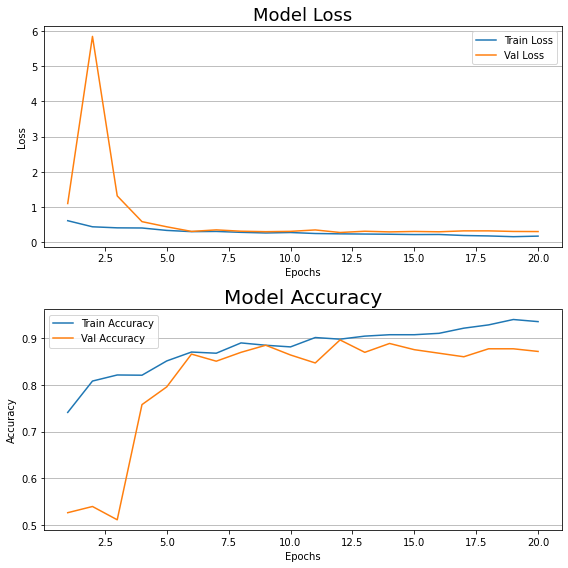

In [125]:
model_performance(hist)

And a quick evaluation of each set:

In [126]:
model2.evaluate(x_train, y_train)

66/66 [==============================] - 64s 969ms/step - loss: 0.0911 - accuracy: 0.9649


[0.09111281484365463, 0.9649122953414917]

In [127]:
model2.evaluate(x_val, y_val)

17/17 [==============================] - 16s 953ms/step - loss: 0.3099 - accuracy: 0.8712


[0.309896320104599, 0.8712121248245239]

In [128]:
model2.evaluate(x_test, y_test)

49/49 [==============================] - 49s 991ms/step - loss: 0.2063 - accuracy: 0.9152


[0.20628032088279724, 0.9152215719223022]

As we can see, our model is not overfit and it produced decent results as seen above: **96% accuracy on our training set, 87% for our validation, and 91% on our test set.**

# 5 Block CNN Models:

## Image Augmentation:

In [159]:
def data_processing(img_dims, batch_size):
    train_data_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_data_gen = ImageDataGenerator(rescale=1./255) #scaling the images to the same range [0,1]
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_generator = train_data_gen.flow_from_directory(
    directory=train_dir, 
    target_size=(img_dims, img_dims),  #Each image will be resized to this size
    batch_size=batch_size, #number of observations that are inputted into the model at one time
    class_mode='binary', 
    shuffle=True)

    test_generator = test_data_gen.flow_from_directory(
    directory=test_dir, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=False)
    
    # In order to plot the Confusion Matrix, I will be making predictions off of the test set in one batch size
    test_data = []
    test_labels = []

    for cond in ['/benign/', '/malignant/']:
        for img in (os.listdir(main_dir + 'test' + cond)):
            img = plt.imread(main_dir+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/benign/':
                label = 0
            elif cond=='/malignant/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_generator, test_generator, test_data, test_labels

In [160]:
import cv2
#Values for later use:
img_dims = 224
epochs = 30
batch_size = 10
train_generator, test_generator, test_data, test_labels = data_processing(img_dims, batch_size)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


# Model 1- CNN:

Defining the model architecture:

In [29]:
inputs = Input(shape=(img_dims, img_dims, 3))

#1st Convolution
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#2nd Convolution
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x) #(15)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#3rd Convolution
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#4th Convolution
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#5th Convolution
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fully Connected layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x) #<--Converting a real value into a interpretable probability

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
#hdf5 (Hierarchical Data Format) is to store the weights of the best performing epoch
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max') #<--Reduce learning rate 
#when the metric has stopped improving.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Fitting the model:

In [30]:
hist = model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, 
           epochs=epochs, validation_data=test_generator, shuffle=True,
           validation_steps=test_generator.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/30
263/263 [==============================] - 81s 309ms/step - loss: 0.5759 - accuracy: 0.7141 - val_loss: 0.7167 - val_accuracy: 0.4545
Epoch 2/30
263/263 [==============================] - 82s 311ms/step - loss: 0.4741 - accuracy: 0.7826 - val_loss: 1.0161 - val_accuracy: 0.5455
Epoch 3/30
263/263 [==============================] - 75s 285ms/step - loss: 0.4702 - accuracy: 0.7903 - val_loss: 0.5226 - val_accuracy: 0.7015
Epoch 4/30
263/263 [==============================] - 78s 297ms/step - loss: 0.4523 - accuracy: 0.7868 - val_loss: 1.3085 - val_accuracy: 0.6258
Epoch 5/30
263/263 [==============================] - 73s 276ms/step - loss: 0.4458 - accuracy: 0.7914 - val_loss: 0.4263 - val_accuracy: 0.8030
Epoch 6/30
263/263 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.8032
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
263/263 [==============================] - 72s 275ms/step - loss: 0.4468 - accuracy: 0.8032 - val_l

Checking our performance:

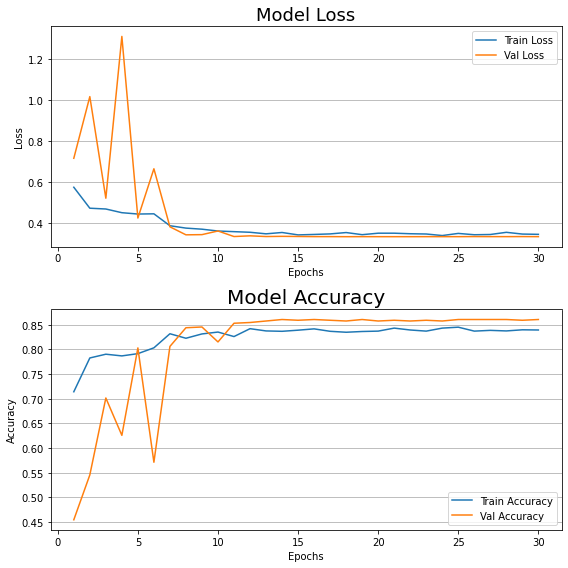

In [31]:
model_performance(hist)

Calculating the confustion matrix:

In [32]:
preds = model.predict(test_generator)

accur = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()
#tp = true positive tn = true negative fp = false positive fn = false negative


print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accur))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train Accuracy: {}'.format(np.round((hist.history["accuracy"][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[298  62]
 [ 30 270]]

TEST METRICS ----------------------
Accuracy: 86.06060606060606%
Precision: 81.32530120481928%
Recall: 90.0%
F1-score: 85.44303797468355

TRAIN METRIC ----------------------
Train Accuracy: 83.94


Visualizing the matrix:

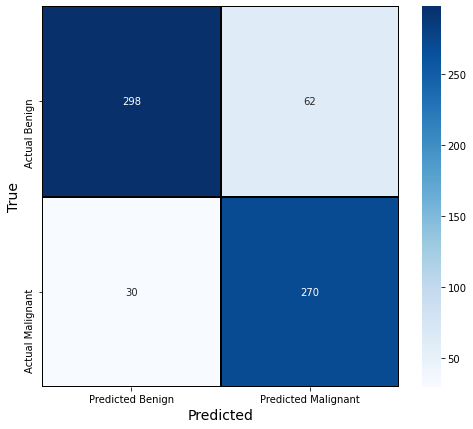

In [33]:
cm = pd.DataFrame(cm, index = ['Actual Benign', 'Actual Malignant'], columns = ['Predicted Benign', 'Predicted Malignant'])
plt.figure(figsize = (8,7))
labels = ['Benign', 'Malignant']
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()


As shown in our matrix, our model produced  semi-decent results with an 86% accuracy score. This means that out of 270 patients, 30 of them may be misdiagnosed as healthy when in fact they have a cancerous lesion. These numbers mean that 1 out of 9 will potentially not receive the care they need due to a wrong diagnosis, and while the numbers aren't too bad, when it comes to the health of a person these numbers are unacceptable. And so, I will continue with a new model:

# Model 4: 

In [156]:
img_dims = 224
inputs = Input(shape=(img_dims, img_dims, 3))

#1st Convolution
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#2nd Convolution
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#3rd Convolution
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#4th Convolution
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.3)(x) #<--Updated dropout rate

#5th Convolution
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.3)(x) #<--Updated dropout rate

# Fully Connected layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.6)(x)  #<--Updated dropout rate
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.4)(x)  #<--Updated dropout rate
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.2)(x) #<--Updated dropout rate

# Output layer
output = Dense(units=1, activation='sigmoid')(x) #<--Converting a real value into a interpretable probability

# Creating model and compiling
model3 = Model(inputs=inputs, outputs=output)
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights4.hdf5', save_best_only=True, save_weights_only=True)
#hdf5 (Hierarchical Data Format) is to store the weights of the best performing epoch
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=2, mode='max') #<--Reduce learning rate 
#when the metric has stopped improving.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=20, mode='min')

In [157]:
model3.input.shape

TensorShape([None, 224, 224, 3])

I'll fit the model with 30 epochs and a larger batch size:

In [161]:
hist = model3.fit(train_generator, epochs=30, validation_data=test_generator,
                  shuffle=True, batch_size = 128, callbacks=[checkpoint, lr_reduce, early_stop])

Epoch 1/30
264/264 [==============================] - 279s 1s/step - loss: 0.6010 - accuracy: 0.6811 - val_loss: 0.6934 - val_accuracy: 0.4545
Epoch 2/30
264/264 [==============================] - 278s 1s/step - loss: 0.4926 - accuracy: 0.7672 - val_loss: 1.3153 - val_accuracy: 0.5455
Epoch 3/30
264/264 [==============================] - 277s 1s/step - loss: 0.4659 - accuracy: 0.7903 - val_loss: 0.5496 - val_accuracy: 0.7333
Epoch 4/30
264/264 [==============================] - 274s 1s/step - loss: 0.4507 - accuracy: 0.7941 - val_loss: 0.4978 - val_accuracy: 0.7848
Epoch 5/30
264/264 [==============================] - 274s 1s/step - loss: 0.4526 - accuracy: 0.8111 - val_loss: 0.4604 - val_accuracy: 0.7803
Epoch 6/30
264/264 [==============================] - 273s 1s/step - loss: 0.4326 - accuracy: 0.8111 - val_loss: 0.3834 - val_accuracy: 0.8136
Epoch 7/30
264/264 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.8157
Epoch 00007: ReduceLROnPlateau reducing learni

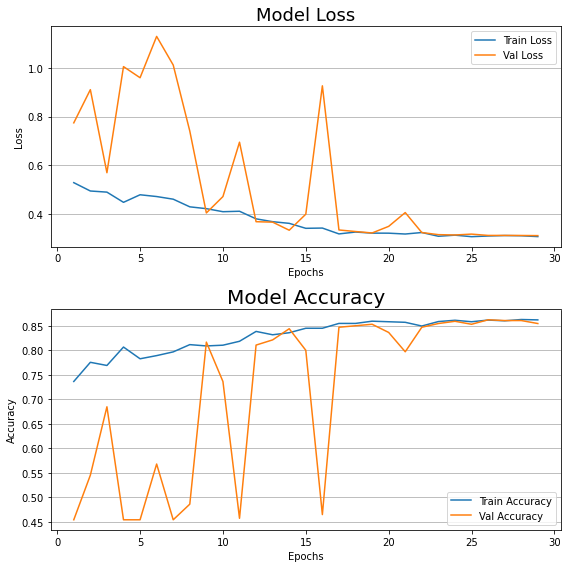

In [142]:
model_performance(hist)

In [145]:
preds = model3.predict(test_generator)

accur = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()
#tp = true positive tn = true negative fp = false positive fn = false negative


print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accur))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train Accuracy: {}'.format(np.round((hist.history["accuracy"][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[302  58]
 [ 38 262]]

TEST METRICS ----------------------
Accuracy: 85.45454545454545%
Precision: 81.875%
Recall: 87.33333333333333%
F1-score: 84.51612903225806

TRAIN METRIC ----------------------
Train Accuracy: 86.2


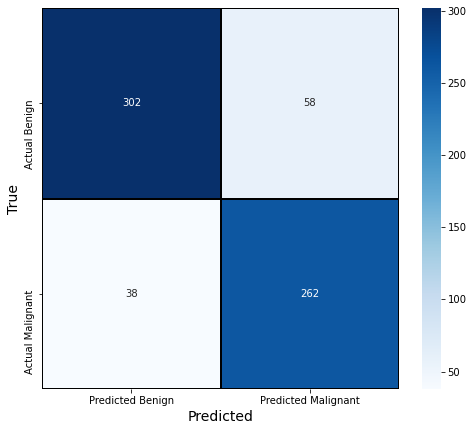

In [146]:
cm = pd.DataFrame(cm, index = ['Actual Benign', 'Actual Malignant'], columns = ['Predicted Benign', 'Predicted Malignant'])
plt.figure(figsize = (8,7))
labels = ['Benign', 'Malignant']
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

So, our accuracy increased a bit from our last model (86% train and 85% test) however according to our confusion matrix, 1 out of 6 will be misdiagnosed as healthy while having cancer. This model has produced less favorable results than our previous one. 

# Model 5: ResNet50:

I will now build my final model using ResNet50 (16), a pretrained image classification model that consists of a 50 layer deep convolutional network. I've chosen this model because since my dataset is large and this particular model has been trained on thousands of images in very deep layers, I am hopeful this will achieve optimal accuracy results. (17)

First, I'll define my image size, the number of epochs, classes, batch size and my data augmentation.

In [4]:
height, width = (224, 224)
epochs = 30 
classes_name = ('benign','malignant')
batch_size = 34
imgdatagen = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=45, #10 
                                     zoom_range = 0.2, 
                                     width_shift_range=0.2,  
                                     height_shift_range=0.2) 

Now I'll augment:

In [52]:
train_aug = imgdatagen.flow_from_directory(train_dir, target_size = (height, width), 
                classes = classes_name,  batch_size = batch_size)

val_aug = imgdatagen.flow_from_directory(test_dir, target_size = (height, width), 
                classes = classes_name, batch_size = batch_size, shuffle=False)


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Next I'll define my model's architecture by not including the top. This means I'll remove the last dense layers to allow the features of my model to be extracted. Then I will compile and finally, fit my model.

In [53]:
base_model= ResNet50(include_top=False, weights="imagenet", input_shape=(height, width,3))
model4= Sequential()
model4.add(base_model)
model4.add(Conv2D(64, (3, 3), activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))
model4.add(Dropout(0.2))
model4.add(Flatten())
model4.add(Dense(512,activation='relu'))
model4.add(Dense(256,activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(128,activation='relu'))
model4.add(Dense(64,activation='relu'))
model4.add(Dense(32,activation='relu'))
model4.add(Dense(16,activation='relu'))
model4.add(Dense(8,activation='relu'))
model4.add(Dense(2, activation='softmax'))
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          1179712   
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [55]:
model4.compile(optimizer=Adam(lr=0.00001),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=.5, min_lr=0.00001) 
hist = model4.fit(train_aug, steps_per_epoch=train_aug.samples//train_aug.batch_size,
                  validation_data=val_aug, verbose=1, validation_steps=val_aug.samples//val_aug.batch_size,
                  epochs=epochs, callbacks=[lr_reduce])

Epoch 1/30
41/41 [==============================] - 985s 24s/step - loss: 0.5905 - accuracy: 0.6436 - val_loss: 0.7216 - val_accuracy: 0.4375
Epoch 2/30
41/41 [==============================] - 1092s 27s/step - loss: 0.4994 - accuracy: 0.7532 - val_loss: 0.8421 - val_accuracy: 0.4375
Epoch 3/30
41/41 [==============================] - 970s 24s/step - loss: 0.4347 - accuracy: 0.8037 - val_loss: 1.0178 - val_accuracy: 0.4375
Epoch 4/30
41/41 [==============================] - 961s 23s/step - loss: 0.4034 - accuracy: 0.8228 - val_loss: 1.3917 - val_accuracy: 0.4375
Epoch 5/30
41/41 [==============================] - 971s 24s/step - loss: 0.3737 - accuracy: 0.8348 - val_loss: 1.4120 - val_accuracy: 0.4375
Epoch 6/30
16/41 [==========>...................] - ETA: 9:49 - loss: 0.3570 - accuracy: 0.8376 

### Evaluation:

In [39]:
model4.evaluate(train_aug)

78/78 [==============================] - 146s 2s/step - loss: 0.0452 - accuracy: 0.9860


[0.04519461840391159, 0.9859688878059387]

In [13]:
model4.evaluate(val_aug)

20/20 [==============================] - 33s 2s/step - loss: 0.3066 - accuracy: 0.9121


[0.3065687119960785, 0.9121212363243103]

#### Plotting Accuracy vs. Loss:

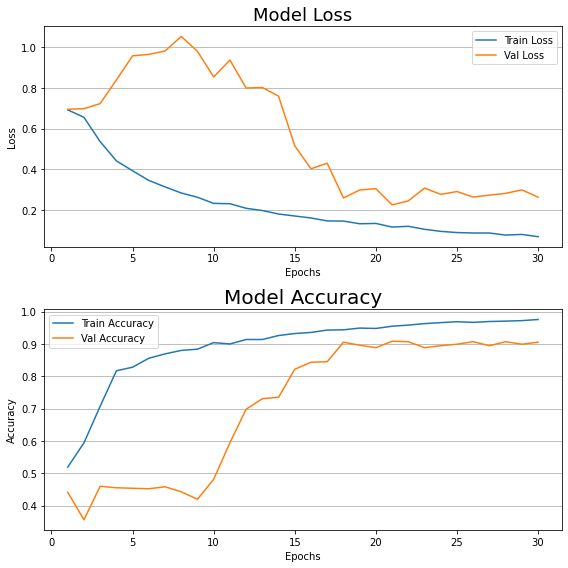

In [43]:
model_performance(hist)

This model is able to achieve a validation accuracy level of **91.2%** which is rather decent over 30 epochs! 

# Conclusion
This project has shown how to benign and malignant diagnosis' from a set of skin lesion images and although it's far from perfect and could be improved, it is amazing to see the success of deep learning being used in real world problems.

# Recommended Next Steps
Re-run the models on the full dataset. I've originally done so, however give that the size of the file is so huge (4.18gb, over 25gb with augmentation), I was only able to run one model every few days (each model produced similar results as the ones aboe) and my kernel kept crashing, ultimately leaving me to keep restarting. However, now that I've completed this notebook I am able to simple update the dataset and rerun!

Re-run some of the models them with a greater number of epochs (such as 100 or more on the ones with 30) if necessary to determine if there is convergence. I've attempted this, however my system couldn't handle it.

Fine tune and test other parameters to reduce overfitting as well as build a model with FN/FP/TN/TP metrics to get a more accurate look when the classes are imbalanced. (18)

With this project as a base, our work can be built upon to detect more complex problems, such as determining the types of cancers, skin diseases related to Agent Orange and more.

Output the model to a user friendly application, preferably a web app.

# References:

(1) https://docs.hashicorp.com/sentinel/imports/decimal

(2) https://www.geeksforgeeks.org/convert-bgr-and-rgb-with-python-opencv/

(3) https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy

(4) https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

(5) https://pythonguides.com/python-print-2-decimal-places/#:~:text=Python%20print%202%20decimal%20places%20In%20Python%2C%20to,will%20print%20the%20float%20with%202%20decimal%20places.

**EfficientNetB0:**

https://keras.io/api/applications/efficientnet/

https://paperswithcode.com/method/efficientnet


(6) https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization

(7) Thank you @python_wizard, @py_lenn, and @synthphreak from reddit for guiding me with this piece of code!

(8) https://keras.io/api/callbacks/

(9) https://keras.io/api/callbacks/reduce_lr_on_plateau/

(10) https://keras.io/api/callbacks/model_checkpoint/

(11) https://keras.io/api/callbacks/early_stopping

(12) https://stackoverflow.com/questions/61362426/why-is-my-val-accuracy-stagnant-at-0-0000e00-while-my-val-loss-is-increasing-fr

(13) https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

(14) https://stats.stackexchange.com/questions/260505/should-i-use-a-categorical-cross-entropy-or-binary-cross-entropy-loss-for-binary#:~:text=Binary%20cross-entropy%20is%20for%20multi-label%20classifications%2C%20whereas%20categorical,Thanks%20for%20contributing%20an%20answer%20to%20Cross%20Validated%21

(15) https://keras.io/api/layers/convolution_layers/separable_convolution2d/

**ResNet50:**

(16) https://iq.opengenus.org/resnet50-architecture/

(17) https://medium.com/@venkinarayanan/tutorial-image-classifier-using-resnet50-deep-learning-model-python-flask-in-azure-4c2b129af6d2

(18) https://keras.io/examples/structured_data/imbalanced_classification/